In [65]:
from zipfile import ZipFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

## Downloading the Data

In [1]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
# kaggle api
!kaggle datasets download -d snap/amazon-fine-food-reviews

Dataset URL: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
License(s): CC0-1.0
100% 242M/242M [00:06<00:00, 41.3MB/s]
100% 242M/242M [00:06<00:00, 38.6MB/s]


In [5]:
# extracting the compressed file
file_path = '/content/amazon-fine-food-reviews.zip'
with ZipFile(file_path, "r") as zip:
  zip.extractall()
  print("The dataset has been extracted...")

The dataset has been extracted...


## Step 0. Reading the Data & NLTK Basics

In [10]:
# Read in the data
df = pd.read_csv("Reviews.csv")
df.shape
df = df.head(500)
df.shape

(500, 10)

### Quick EDA

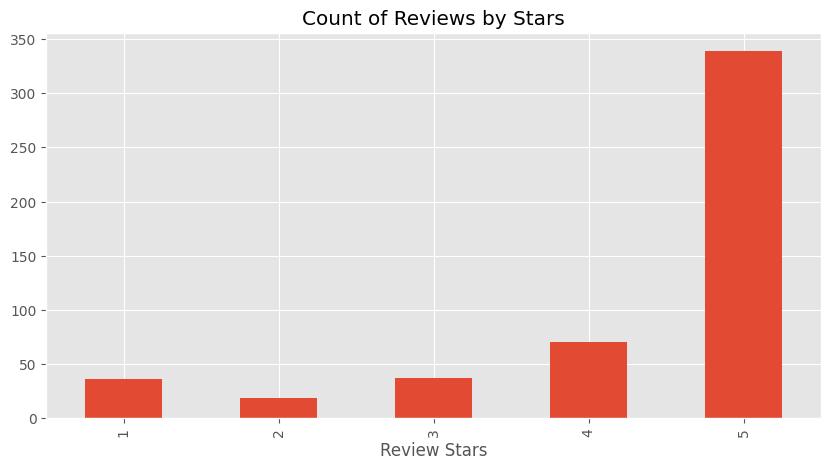

In [19]:
ax = df["Score"].value_counts().sort_index().plot(
    kind='bar',
    title='Count of Reviews by Stars',
    figsize=(10, 5)
  )
ax.set_xlabel("Review Stars")
plt.show()

### Basic NLTK

In [24]:
example = df["Text"][50]
example

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

In [28]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [32]:
tagged = nltk.pos_tag(tokens) # part of speech
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [40]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## Step 1. VADER Sentiment Scoring


In [44]:
sia = SentimentIntensityAnalyzer()

In [45]:
sia.polarity_scores("I am so happy.")

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [46]:
sia.polarity_scores("This is the worst thing ever.")

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [47]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [49]:
# Run the polarity score on the entire dataset
res = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
  text = row["Text"]
  myId = row['Id']
  res[myId] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [55]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={"index": "Id"})
vaders = vaders.merge(df, how='left')

In [56]:
# Now we have sentiment score and meta data
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Plot VADER results

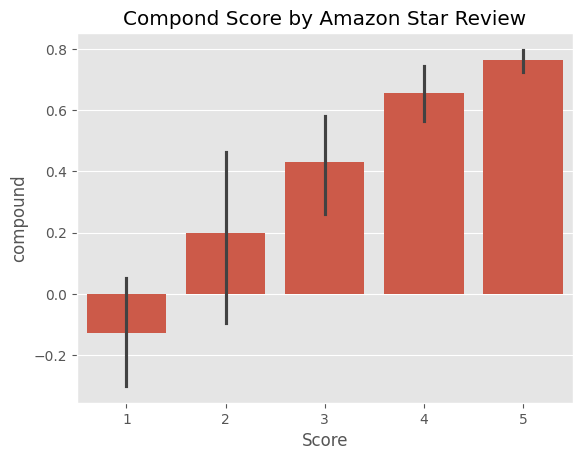

In [58]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compond Score by Amazon Star Review')
plt.show()

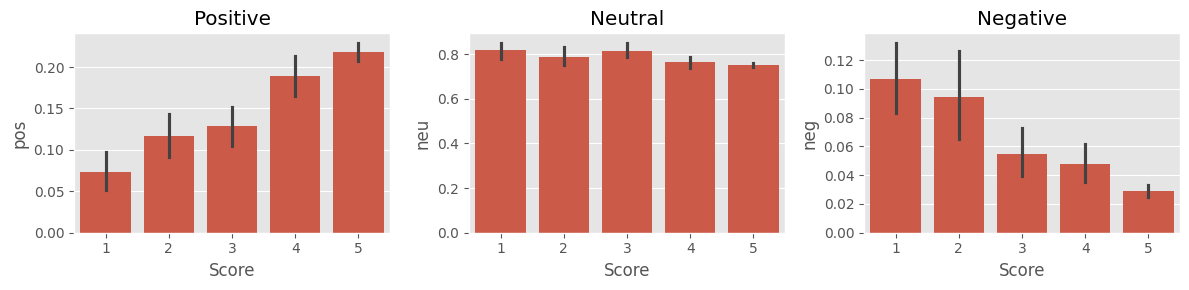

In [62]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")
plt.tight_layout()
plt.show()

## Step 2. Roberta Pretrained Model

In [68]:
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [69]:
# VADER Rsults
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [71]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687465, 'roberta_pos': 0.0029573692}


In [72]:
def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors='pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
  }
  return scores_dict

In [86]:
# Run the polarity score on the entire dataset - Roberta Model
res = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
  try:
    text = row["Text"]
    myId = row['Id']

    vader_result = sia.polarity_scores(text)

    vader_result_rename = {}
    for key, value in vader_result.items():
      vader_result_rename[f"vader_{key}"] = value

    roberta_result = polarity_scores_roberta(text)

    both_results = {**vader_result_rename, **roberta_result}
    res[myId] = both_results

  except RuntimeError:
    print(f'Broke for id {myId}')


  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [87]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={"index": "Id"})
results_df = results_df.merge(df, how='left')

## Step 3.Comparing Scores between models

In [ ]:
sns.pairplot(
    data=results_df,
    vars=['vader_neg', 'vader_neu','vader_pos', 'roberta_neg', 'roberta_neu', 'roberta_pos'],
    hue='Score',
    palette='tab10'
)
plt.show()

## Step 4. Review Examples

In [92]:
results_df.query('Score == 1').sort_values('roberta_pos', ascending=False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [93]:
results_df.query('Score == 1').sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [95]:
# negative sentiment 5-star review
results_df.query('Score == 5').sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [98]:
results_df.query('Score == 5').sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

## Extra: The Transformers Pipeline

In [100]:
from transformers import pipeline

In [101]:
sent_pipeline = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [102]:
sent_pipeline('i love sentiment analysis')

[{'label': 'POSITIVE', 'score': 0.999736487865448}]

In [103]:
sent_pipeline('this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault')

[{'label': 'NEGATIVE', 'score': 0.9980344176292419}]

In [104]:
sent_pipeline(
    'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink.\
     I could have just drunk a cup of coffee and saved my money.')

[{'label': 'NEGATIVE', 'score': 0.9976904392242432}]